<a href="https://colab.research.google.com/github/GiuliaTuccio/ScalableML-DL/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Project**


In this project we build a reccomandation system for music based on the notion of spectogram; a picture created starting by an mp3 file, and representing the frequences with respect to time.

The mp3 file are downloaded on the page https://github.com/mdeff/fma, containing 8000 songs, belonging to one of the 8 following genres:
1. Hip-Hop
2. International
3. Electronic
4. Folk
5. Experimental
6. Rock
7. Pop
8. Instrumental

As soon as the spectograms are generated, we proceed into cutting the images into the desired shape (128x128) and converting them into greyscale.

Successively, we build the classification network and proceed with the training.

Finnally, we discerd the last layer (producing the classification of the songs), keeping the dense layer made by 32-features vector.
The features will be used to compute the reccomondation system based on the cosine similarity, between a song inputed by the user and the 'Test' set.

Importing the necessary libraries

In [1]:
!pip install tensorflow

import os
import pandas as pd
import re
import math
import numpy as np
import soundfile as sf
from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image 
from keras.models import Sequential
from keras import initializers
from keras import optimizers
from keras.layers import *
from keras.utils.vis_utils import plot_model

import cv2
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers

from sklearn.metrics import classification_report,confusion_matrix

Importing Google Drive, where the songs are saved

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Uploading the excel file containing the information about the songs.

The first column contains the id, whereas the 41st column defines the genre of the song

In [ ]:
# Upload the data set containing the informations about the songs

filename_metadata = "/content/gdrive/MyDrive/tracks.csv"
tracks = pd.read_csv(filename_metadata, header=2)

print(tracks['Unnamed: 40'].value_counts())

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: Unnamed: 40, dtype: int64


In [ ]:
tracks_array = tracks.values

# extract the information
tracks_id_array = tracks_array[: , 0]
tracks_genre_array = tracks_array[: , 40]

# save the id and the genre in an array
tracks_id_array = tracks_id_array.reshape(tracks_id_array.shape[0], 1)

tracks_genre_array = tracks_genre_array.reshape(tracks_genre_array.shape[0], 1)

The following code is a trial for one folder.

Firstly, a directory cointaining the spectogram images is created.

Then, a loop goes through each of the mp3 files, saves the index and the genre, and uses the library librosa to generate the spectogram.

The spectogram is then converted in decibel units (melspectogram) and saved as a jpg image.

In [ ]:
if not os.path.exists('/content/gdrive/MyDrive/Val_Spectogram'):
            os.makedirs('/content/gdrive/MyDrive/Val_Spectogram')

folder_sample = '/content/gdrive/MyDrive/music-data/154'
            

file_names = [os.path.join(folder_sample, f)
                  for f in os.listdir(folder_sample)
                  if f.endswith(".mp3")]

count = 0
           
for f in file_names:
    #track_id = int(re.search('/content/gdrive/MyDrive/music-data/.*/(.+?).mp3', f).group(1))
    track_id = int(re.search('/content/gdrive/MyDrive/music-data/154/(.+?).mp3', f).group(1))
    print(track_id)
    idx = list(tracks_id_array).index(track_id)
    
    # returns audio time series and sampling rate
    y, sr =  librosa.load(f)
    # Display of mel-frequency spectrogram coefficients
    melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    # Convert a power spectrogram (amplitude squared) to decibel (dB) units
    mel = librosa.power_to_db(melspectrogram_array)
    # Save the images of the spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(mel.shape[1]) / float(100)
    fig_size[1] = float(mel.shape[0]) / float(100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel, cmap='gray_r')
    plt.savefig("/content/gdrive/MyDrive/Val_Spectogram/"+str(count)+"_"+str(tracks_genre_array[idx,0])+".jpg", bbox_inches=None, pad_inches=0)
    plt.close()
    count += 1

Here the same procedure is replicated for all the mp3 files in the dataset

In [ ]:
count = 0
if not os.path.exists('/content/Train_Spectogram_Images'):
            os.makedirs('/content/Train_Spectogram_Images')

folder_sample = '/content/gdrive/MyDrive/music-data'
directories = [d for d in os.listdir(folder_sample)
                 if os.path.isdir(os.path.join(folder_sample, d))]
              
for d in directories:
    label_directory = os.path.join(folder_sample, d)
    file_names = [os.path.join(label_directory, f)
                  for f in os.listdir(label_directory)
                  if f.endswith(".mp3")]
            
    for f in file_names:
        print(file_names)
        track_id = int(re.search('/content/gdrive/MyDrive/music-data/.*/(.+?).mp3', f).group(1))
        print(track_id)
        #print(track_id)
        idx = list(tracks_id_array).index(track_id)
        # returns audio time series and sampling rate
        y, sr =  librosa.load(f)
        # Display of mel-frequency spectrogram coefficients
        melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        # Convert a power spectrogram (amplitude squared) to decibel (dB) units
        mel = librosa.power_to_db(melspectrogram_array)
        # Save the images of the spectogram
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = float(mel.shape[1]) / float(100)
        fig_size[1] = float(mel.shape[0]) / float(100)
        plt.rcParams["figure.figsize"] = fig_size
        plt.axis('off')
        plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
        librosa.display.specshow(mel, cmap='gray_r')
        plt.savefig("'/content/Train_Spectogram_Images'"+str(count)+"-"+str(tracks_genre_array[idx,0])+".jpg", bbox_inches=None, pad_inches=0)
        plt.close()
        count += 1

The spectograms created are then converted into a picture of the desired dimensions. 

This means that all the images are cropped. The genre is saved as the name of the image.

In [ ]:
# Create folder for sliced images
if not os.path.exists('/content/Train_Sliced_Images'):
            os.makedirs('/content/Train_Sliced_Images')

DEF_SIZE = 128

folder_sample = '/content/gdrive/MyDrive/Train_spectogram_Images'
directories = [d for d in os.listdir(folder_sample)
                 if os.path.isdir(os.path.join(folder_sample, d))]
counter = 0             
for d in directories:
    label_directory = os.path.join(folder_sample, d)
    file_names = [os.path.join(label_directory, f)
                  for f in os.listdir(label_directory)
                  if f.endswith(".jpg")]
            
    for f in file_names:
      genre = re.search('/content/gdrive/MyDrive/Train_spectogram_Images/.*/.*_(.+?).jpg', f).group(1)
      #print(genre)
      img = Image.open(f)
      w, h = img.size
      # understand how many sliced images for each spectogram
      num_slices = w // DEF_SIZE
      for i in range(num_slices):
        left_ = i*DEF_SIZE  
        img_sliced = img.crop((left_, 0., left_+DEF_SIZE, DEF_SIZE)) # left, top, right, bottom
        img_sliced.save("/content/Train_Sliced_Images/"+str(counter)+"_"+genre+".jpg")
        counter += 1
        #print(counter)

In [ ]:
# Create folder for sliced images
if not os.path.exists('/content/gdrive/MyDrive/Val_Sliced_Images'):
            os.makedirs('/content/gdrive/MyDrive/Val_Sliced_Images')

DEF_SIZE = 128

folder_sample = '/content/gdrive/MyDrive/Val_Spectogram'
            

file_names = [os.path.join(folder_sample, f)
                  for f in os.listdir(folder_sample)
                  if f.endswith(".jpg")]
counter=0

for f in file_names:
  genre = re.search('/content/gdrive/MyDrive/Val_Spectogram/.*_(.+?).jpg', f).group(1)
  #print(genre)
  img = Image.open(f)
  w, h = img.size
  # understand how many sliced images for each spectogram
  num_slices = w // DEF_SIZE
  for i in range(num_slices):
    left_ = i*DEF_SIZE  
    img_sliced = img.crop((left_, 0., left_+DEF_SIZE, DEF_SIZE)) # left, top, right, bottom
    img_sliced.save("/content/gdrive/MyDrive/Val_Sliced_Images/"+str(counter)+"_"+genre+".jpg")
    counter += 1
    #print(counter)

The images are then saved as npy files, easier to manage.

The labels are converted in one-hot encoding and splitted into train and test sets.

In [ ]:
# Convert the data set into grey-scale images and associate it with the label for the training phase

## TO DO CREATE FUNCTION LOAD DATA SET
genre = {
        "Hip-Hop": 0,
        "International": 1,
        "Electronic": 2,
        "Folk" : 3,
        "Experimental": 4,
        "Rock": 5,
        "Pop": 6,
        "Instrumental": 7
        }

spectogram_images = [os.path.join('/content/Train_Sliced_Images', f)
                          for f in os.listdir('/content/Train_Sliced_Images')
                          if f.endswith(".jpg")]


images_all = [None]*(len(spectogram_images))
labels_all = [None]*(len(spectogram_images))


In [ ]:
print(len(spectogram_images))
for f in spectogram_images:
    idx = int(re.search('/content/Train_Sliced_Images/(.+?)_.*.jpg', f).group(1))
    genre_var = re.search('/content/Train_Sliced_Images/.*_(.+?).jpg', f).group(1)
    
    temp = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    images_all[idx] = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    labels_all[idx] = genre[genre_var]
    

49791


In [ ]:
images = np.array(images_all)
labels = np.array(labels_all)
labels = labels.reshape(labels.shape[0],1)
train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.1, shuffle=True)

In [ ]:
# Convert the labels into one-hot vectors.
n_classes = len(genre)
train_y = np_utils.to_categorical(train_y, num_classes=n_classes)
test_y = np_utils.to_categorical(test_y, num_classes=n_classes)

genre_new = {value: key for key, value in genre.items()}



In [ ]:
if os.path.exists('/content/gdrive/MyDrive/Training_Data_Giulia'):
    train_x = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/train_x.npy")
    train_y = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/train_y.npy")
    test_x = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/test_x.npy")
    test_y = np.load("/content/gdrive/MyDrive/Training_Data_Giulia/test_y.npy")
    

if not os.path.exists('/content/gdrive/MyDrive/Training_Dat_Giuliaa'):
    os.makedirs('/content/gdrive/MyDrive/Training_Data_Giulia')
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/train_x.npy", train_x)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/train_y.npy", train_y)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/test_x.npy", test_x)
np.save("/content/gdrive/MyDrive/Training_Data_Giulia/test_y.npy", test_y)

Here we are pre processing an unseen part of the training data set to build the confusing matrix and test the predictions made by our network

In [ ]:
# Convert the data set into grey-scale images and associate it with the label for the training phase

## TO DO CREATE FUNCTION LOAD DATA SET
genre = {
        "Hip-Hop": 0,
        "International": 1,
        "Electronic": 2,
        "Folk" : 3,
        "Experimental": 4,
        "Rock": 5,
        "Pop": 6,
        "Instrumental": 7
        }

spectogram_images = [os.path.join('/content/gdrive/MyDrive/Val_Sliced_Images', f)
                          for f in os.listdir('/content/gdrive/MyDrive/Val_Sliced_Images')
                          if f.endswith(".jpg")]


images_all = [None]*(len(spectogram_images))
labels_all = [None]*(len(spectogram_images))


In [ ]:
print(len(spectogram_images))
for f in spectogram_images:
    idx = int(re.search('/content/gdrive/MyDrive/Val_Sliced_Images/(.+?)_.*.jpg', f).group(1))
    genre_var = re.search('/content/gdrive/MyDrive/Val_Sliced_Images/.*_(.+?).jpg', f).group(1)
    
    temp = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    images_all[idx] = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    labels_all[idx] = genre[genre_var]

182


In [ ]:
images = np.array(images_all)
labels = np.array(labels_all)
labels = labels.reshape(labels.shape[0],1)
#train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.1, shuffle=True)

In [ ]:
# Convert the labels into one-hot vectors.
n_classes = len(genre)
v_y = np_utils.to_categorical(labels, num_classes=n_classes)

genre_new = {value: key for key, value in genre.items()}



In [ ]:
if os.path.exists('/content/gdrive/MyDrive/V_Giulia'):
    v_x = np.load("/content/gdrive/MyDrive/V_Giulia/v_x.npy")
    v_y = np.load("/content/gdrive/MyDrive/V_Giulia/v_y.npy")
   

if not os.path.exists('/content/gdrive/MyDrive/V_Giulia'):
    os.makedirs('/content/gdrive/MyDrive/V_Giulia')
np.save("/content/gdrive/MyDrive/V_Giulia/v_x.npy", images)
np.save("/content/gdrive/MyDrive/V_Giulia/v_y.npy", v_y)


After completing the first phase of preprocessing we just need to upload the npy files

In [51]:
train_x = np.load('/content/gdrive/MyDrive/Training_Data/train_x.npy')
test_x = np.load('/content/gdrive/MyDrive/Training_Data/test_x.npy')
train_y = np.load('/content/gdrive/MyDrive/Training_Data/train_y.npy')
test_y = np.load('/content/gdrive/MyDrive/Training_Data/test_y.npy')

In [52]:
train_y.shape, train_x.shape

((44711, 8), (44711, 128, 128))

To shuffle also the validation set

In [53]:
train_x_1, val_x, train_y_1, val_y = train_test_split(train_x, train_y, test_size=0.10, shuffle=True)

In [54]:
train_x_1.shape, train_y_1.shape

((40239, 128, 128), (40239, 8))

Expand the dimension of the image to one channel (grey scale images) (nx128x128x1)

In [55]:
train_x = train_x_1.reshape(train_x_1.shape[0], train_x_1.shape[1], train_x_1.shape[2], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2], 1)


In [56]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y_1))
val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))

Check if the data are split in the three datasets (training, validation and test) in a balanced way

In [57]:
a = np.argmax(val_y, axis=1)
for i in np.unique(a):
  print(np.count_nonzero(a==i))


500
591
559
604
645
492
604
477


In [58]:
b = np.argmax(train_y_1, axis=1)
for i in np.unique(b):
  print(np.count_nonzero(b==i))

4743
5204
4922
5205
5339
4904
5321
4601


In [59]:
c = np.argmax(test_y, axis=1)
for i in np.unique(c):
  print(np.count_nonzero(c==i))

616
673
602
666
638
617
641
515


In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalize the data

In [61]:
normalization_layer = layers.Rescaling(1./255)
val_ds = val_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.batch(128).map(lambda x, y: (normalization_layer(x), y))

In [62]:
# import regularizer
from keras import regularizers
from keras.regularizers import l2


In [ ]:
if not os.path.exists('/content/gdrive/MyDrive/Saved_Model_Batch'):
  os.mkdir('/content/gdrive/MyDrive/Saved_Model_Batch')


# HERE WE TRY TO IMPROVE THE PREVIOUS RESULT BY ADDING A BATCH NORMALIZATION LAYER AFTER
# EACH CONVOLUTIONAL LAYER


model = Sequential()
model.add(Conv2D(filters=64, kernel_size=[7,7], activation="relu", kernel_regularizer=regularizers.l2(0.0001), input_shape=(128,128,1)))
# Dim = (122x122x64)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (61x61x64)
model.add(Conv2D(filters=128, kernel_size=[7,7], strides=2, kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (28x28x128)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (14x14x128)
model.add(Conv2D(filters=256, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (12x12x256)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (6x6x256)
model.add(Conv2D(filters=512, kernel_size=[3,3], kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
# Dim = (4x4x512)
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=[2,2], strides=2))
# Dim = (2x2x512)
model.add(BatchNormalization())
model.add(Flatten())
# Dim = (2048)
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1024, activation="elu"))
# Dim = (1024)
model.add(Dropout(0.5))
model.add(Dense(256, activation="elu"))
# Dim = (256)
model.add(Dropout(0.25))
model.add(Dense(64, activation="elu"))
# Dim = (64)
model.add(Dense(32, activation="elu"))
# Dim = (32)
model.add(Dense(8, activation="softmax"))
# Dim = (8)
print(model.summary())


# compile
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Save the training history
history = model.fit(train_ds, epochs=50, verbose=1,  validation_data=val_ds)
#pd.DataFrame(model.fit(train_x, train_y, batch_size=64, epochs=5, verbose=1, validation_split=0.1).history).to_csv("/content/gdrive/MyDrive/Saved_Model_Batch/training_history.csv")

# evaluate on the test set
score = model.evaluate(test_ds, verbose=1)
print(score)



In [ ]:
# save the training history
pd.DataFrame(history.history).to_csv('/content/gdrive/MyDrive/Saved_Model_Batch/my_model_50.csv')


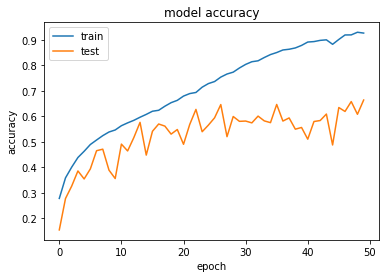

In [ ]:
# show the learning curves

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# show the learning curves

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
labels = [ "Hip-Hop", "International", "Electronic",  "Folk", "Experimental",  "Rock",  "Pop", "Instrumental"]

In [ ]:
loaded_model_1 = load_model("/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5")

In [ ]:
loaded_model_1.evaluate(test_ds, verbose=1)

39/39 [==============================] - 82s 2s/step - loss: 1.5271 - accuracy: 0.6753


[1.527138352394104, 0.675301194190979]

In [ ]:
p = loaded_model_1.predict(v_x)

In [ ]:
p_ = np.argmax(p, axis=1)

In [ ]:
np.unique(p_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
true_labels = v_y

In [ ]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0,
       0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7,
       2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3,
       3, 3, 3, 3, 3, 3])

In [ ]:
print(classification_report(true_labels, p_, target_names = labels))

               precision    recall  f1-score   support

      Hip-Hop       0.81      0.43      0.56        49
International       0.73      0.34      0.46        56
   Electronic       0.09      0.71      0.16         7
         Folk       0.32      0.86      0.46         7
 Experimental       0.00      0.00      0.00         0
         Rock       0.00      0.00      0.00         0
          Pop       0.37      0.29      0.32        35
 Instrumental       0.62      0.18      0.28        28

     accuracy                           0.36       182
    macro avg       0.37      0.35      0.28       182
 weighted avg       0.63      0.36      0.42       182



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


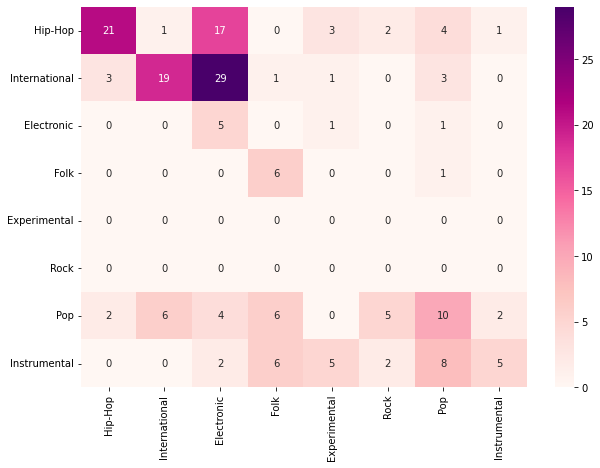

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(true_labels, p_)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

In [ ]:
# save the model
model.save('/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5')

**Using transfer learning and comparing with the network build by us**

In order to improve the performance, we will try to use a pretrained network VGG, which will use colored images.

In [ ]:
img_input = tf.keras.layers.Input(shape=(128, 128,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    

model_vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=img_conc)

x = Flatten()(model_vgg.output)

x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(512, activation="elu")(x)

x = Dropout(0.5)(x)
x = Dense(256, activation="elu")(x)
# Dim = (256)
x = Dropout(0.25)(x)
x = Dense(64, activation="elu")(x)
# Dim = (64)
x = Dense(32, activation="elu")(x)
# Dim = (32)
x = Dense(8, activation="softmax")(x)
# Dim = (8)
print(model_vgg.summary())

transfer_model = tf.keras.Model(inputs=img_input, outputs=x)
# compile
transfer_model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['accuracy'])


save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
        monitor='val_loss', save_best_only=True)
# Save the training history
history_vgg = transfer_model.fit(train_ds, epochs=20, verbose=1,  validation_data=val_ds, callbacks=save_best_model)
#pd.DataFrame(model.fit(train_x, train_y, batch_size=64, epochs=5, verbose=1, validation_split=0.1).history).to_csv("/content/gdrive/MyDrive/Saved_Model_Batch/training_history.csv")

# evaluate on the test set
score_vgg = transfer_model.evaluate(test_ds, verbose=1)
print(score_vgg)

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['concatenate_1[0][0]']      

In [ ]:
# save the training history
if not os.path.exists('/content/gdrive/MyDrive/Saved_Model_vgg'):
  os.mkdir('/content/gdrive/MyDrive/Saved_Model_vgg')

pd.DataFrame(history_vgg.history).to_csv('/content/gdrive/MyDrive/Saved_Model_vgg/my_model_50.csv')

In [ ]:
from keras.models import Model, load_model

In [ ]:
loaded_model_vgg = load_model("/content/gdrive/MyDrive/Saved_Model_vgg/Model.h5")

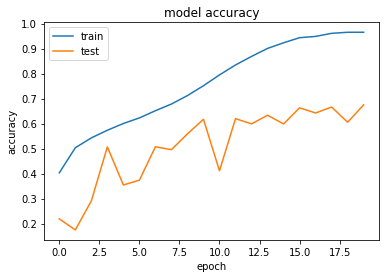

In [ ]:
# show the learning curves

plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

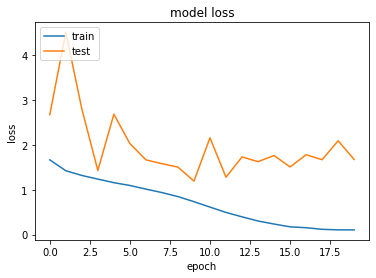

In [ ]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions_vgg = loaded_model_vgg.predict(v_x)

In [ ]:
p_vgg = np.argmax(predictions_vgg, axis=1)

In [ ]:
np.unique(p_vgg)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
print(classification_report(true_labels, p_vgg, target_names = labels))

               precision    recall  f1-score   support

      Hip-Hop       0.85      0.45      0.59        49
International       0.80      0.21      0.34        56
   Electronic       0.20      0.29      0.24         7
         Folk       0.78      1.00      0.88         7
 Experimental       0.00      0.00      0.00         0
         Rock       0.00      0.00      0.00         0
          Pop       0.28      0.54      0.37        35
 Instrumental       0.43      0.21      0.29        28

     accuracy                           0.37       182
    macro avg       0.42      0.34      0.34       182
 weighted avg       0.63      0.37      0.42       182



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


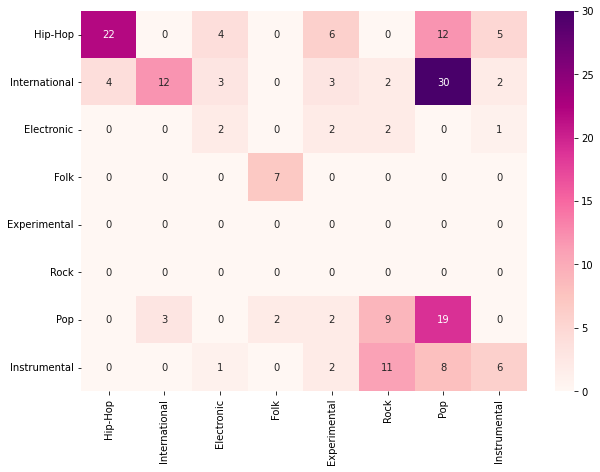

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(true_labels, p_vgg)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [ ]:
# save the model
transfer_model.save('/content/gdrive/MyDrive/Saved_Model_vgg/Model.h5')

**Reccomendation system implementation**

In this section, the reccomenation system is build.

We will upload a set of 33 10-seconds frames downloaded by the free library https://www-ai.cs.tu-dortmund.de/audio.html.

The reccomendation system, given a title of a song as input will provide the two most similar songs in the manually created dataset based on the cosine similarity score.

The songs are pre-processed, as in the training phase: they are converted into a spectogram, then sliced, and saved.

In this case, the label is the title of the song itself.

Although we tried to use transfer learning in the training phase, for the reccomantadion part we eill use the model build by us.

In [ ]:
from keras.models import Model, load_model

In [ ]:
# Load the trained model

loaded_model = load_model("/content/gdrive/MyDrive/Saved_Model_Batch/Model.h5")
loaded_model.set_weights(loaded_model.get_weights())

# Discard the Softmax layer, Second last layer provides the latent feature
# representation.
matrix_size = loaded_model.layers[-2].output.shape[1]
new_model = Model(loaded_model.inputs, loaded_model.layers[-2].output)
print(new_model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 128, 128, 1)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      3200      
                                                                 
 batch_normalization_6 (Batc  (None, 122, 122, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_4 (Averag  (None, 61, 61, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       401536    
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 128)      512   

In [ ]:
# latent vector of features dimension

matrix_size

32

In [ ]:
# Upload the data set containing the informations about the songs for the recommandation part
# to perform some explanatory analysis

filename_metadata = "/content/gdrive/MyDrive/test-Set/test-metadat.xlsx"
tracks = pd.read_excel(filename_metadata, header=0)

print(tracks['genre'].value_counts())

Folk            6
Electronic      6
Rock            6
Pop             6
Hip-Hop         5
Experimental    4
Name: genre, dtype: int64


In [ ]:
tracks_array = tracks.values

In [ ]:
# extract the information
tracks_id_array = tracks_array[: , 0]
tracks_genre_array = tracks_array[: , 2]

print(tracks_id_array, tracks_genre_array)

['Amanda_Meza_Here_I_Am.mp3' 'Adrienne_Stiefel_All_I_Know.mp3'
 'Adam_Saul_Bloch_Orchard_Drive.mp3' 'AccoladeUK_Sleep_Tonight.mp3'
 'Allegra_Skyline.mp3' 'Londra_Nothing_Happened.mp3' 'Aidy_Jagstang.mp3'
 'Banana_Fish_Zero_I_Like_A_Lot.mp3' 'Animal_Pharm_Superstar.mp3'
 'Battery_Park_B_T_C_.mp3' 'Flat_Stanley_Money.mp3' 'Yellow_Five_Fool.mp3'
 'Aaron_Wilkinson_Osho_mask.mp3' 'anne_davis_where_the_roads_cross.mp3'
 'Christopher_Dallman-The_7th_of_September.mp3'
 'Emory_Joseph_Daddy_John.mp3' 'Rebecca_Hall_Hard_Way_to_Learn.mp3'
 'JC_Smith_Dulcinea.mp3' 'Appogee_I_m_Yours.mp3'
 'Lucy_in_the_Sky-The_impossible_planet.mp3'
 'Diemembrence-AbolishThyHeavens.mp3' 'Timothy_Allan-Off_the_Mark.mp3'
 'Waldo-Midnight.mp3' 'Miss_Volatile-Morph.mp3'
 'dallas_orbiter-Bed_of_Stars.mp3' 'Dopamine-Tempermentally.mp3'
 'hostmom-it_s_close_up_far_away.mp3' 'Loomis-It_s_Too_Hard.mp3'
 'Apakacrakers-Hotter.mp3' 'blurred_insight-Longer_than_a_Lifetime.mp3'
 'Charli_Funk-Bump.mp3' 'Flipside-Creepin__In.mp3'
 

In [ ]:
# convert into spectograms using librosa library and save in the folder

if not os.path.exists('/content/gdrive/MyDrive/Test_Spectogram'):
            os.makedirs('/content/gdrive/MyDrive/Test_Spectogram')

folder_sample = '/content/gdrive/MyDrive/test-Set'
            

file_names = [os.path.join(folder_sample, f)
                  for f in os.listdir(folder_sample)
                  if f.endswith(".mp3")]

for f in file_names:
    author_f = re.search('/content/gdrive/MyDrive/test-Set/(.+?)-.*.mp3', f).group(1)
    title_f = re.search('/content/gdrive/MyDrive/test-Set/.*-(.+?).mp3', f).group(1)

    # returns audio time series and sampling rate
    y, sr =  librosa.load(f)
    # Display of mel-frequency spectrogram coefficients
    melspectrogram_array = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    # Convert a power spectrogram (amplitude squared) to decibel (dB) units
    mel = librosa.power_to_db(melspectrogram_array)
    # Save the images of the spectogram
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = float(mel.shape[1]) / float(100)
    fig_size[1] = float(mel.shape[0]) / float(100)
    plt.rcParams["figure.figsize"] = fig_size
    plt.axis('off')
    plt.axes([0., 0., 1., 1.0], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(mel, cmap='gray_r')
    plt.savefig("/content/gdrive/MyDrive/Test_Spectogram/"+str(author_f)+"-"+str(title_f)+".jpg", bbox_inches=None, pad_inches=0)
    plt.close()


In [ ]:
# Create folder for sliced images and slice them

if not os.path.exists('/content/gdrive/MyDrive/Test_Sliced_Images'):
            os.makedirs('/content/gdrive/MyDrive/Test_Sliced_Images')

DEF_SIZE = 128

folder_sample = '/content/gdrive/MyDrive/Test_Spectogram'
file_names = [os.path.join(folder_sample, f)
                  for f in os.listdir(folder_sample)
                  if f.endswith(".jpg")]        
count = 0
for f in file_names:
  author_f = re.search('/content/gdrive/MyDrive/Test_Spectogram/(.+?)-.*.jpg', f).group(1)
  title_f = re.search('/content/gdrive/MyDrive/Test_Spectogram/.*-(.+?).jpg', f).group(1)
  img = Image.open(f)
  w, h = img.size
  # understand how many sliced images for each spectogram
  num_slices = w // DEF_SIZE
  print(num_slices)
  for i in range(num_slices):
    left_ = i*DEF_SIZE  
    img_sliced = img.crop((left_, 0., left_+DEF_SIZE, DEF_SIZE)) # left, top, right, bottom
    img_sliced.save("/content/gdrive/MyDrive/Test_Sliced_Images/"+str(count)+"|"+str(author_f)+"-"+str(title_f)+".jpg")
    count = count + 1

In [ ]:
# create the labeled data set; the label is the title of the song
# convert the image into grey scale 

filenames = [os.path.join("/content/gdrive/MyDrive/Test_Sliced_Images", f) for f in os.listdir("/content/gdrive/MyDrive/Test_Sliced_Images")
                    if f.endswith(".jpg")]
images = []
labels = []
for f in filenames:
    song_variable = re.search('Test_Sliced_Images/.*-(.+?).jpg', f).group(1)
    tempImg = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    images.append(cv2.cvtColor(tempImg, cv2.COLOR_BGR2GRAY))
    labels.append(song_variable)

images = np.array(images)

In [ ]:
images.shape

(66, 128, 128)

Since every song is 10 seconds long, two slices are generated for each song

In [ ]:
labels

['I_m_Yours',
 'I_m_Yours',
 'Bed_of_Stars',
 'Bed_of_Stars',
 'Tempermentally',
 'Tempermentally',
 'AbolishThyHeavens',
 'AbolishThyHeavens',
 'it_s_close_up_far_away',
 'it_s_close_up_far_away',
 'The_impossible_planet',
 'The_impossible_planet',
 'It_s_Too_Hard',
 'It_s_Too_Hard',
 'Morph',
 'Morph',
 'Off_the_Mark',
 'Off_the_Mark',
 'Midnight',
 'Midnight',
 'Skyline',
 'Skyline',
 'All_I_Know',
 'All_I_Know',
 'Taste_the_Shit',
 'Taste_the_Shit',
 'Wish_that_they_could_hear_us',
 'Wish_that_they_could_hear_us',
 'Here_I_Am',
 'Here_I_Am',
 'Nothing_Happened',
 'Nothing_Happened',
 'Superstar',
 'Superstar',
 'Orchard_Drive',
 'Orchard_Drive',
 'I_Like_A_Lot',
 'I_Like_A_Lot',
 'Bump',
 'Bump',
 'Hotter',
 'Hotter',
 'Fool',
 'Fool',
 'Dream__Featuring_Antonia_Jenae_',
 'Dream__Featuring_Antonia_Jenae_',
 'Creepin__In',
 'Creepin__In',
 'Money',
 'Money',
 'Jagstang',
 'Jagstang',
 'B_T_C_',
 'B_T_C_',
 'Osho_mask',
 'Osho_mask',
 'Daddy_John',
 'Daddy_John',
 'Hard_Way_to_Learn'

In [ ]:
# expand the image so that it have 1 channel, meaning grey scale

images = np.expand_dims(images, axis=3)
images.shape

(66, 128, 128, 1)

In [ ]:
# Normalize the image

images = images / 255.

In [ ]:
# Display list of available test songs

print(np.unique(labels))

['AbolishThyHeavens' 'All_I_Know' 'B_T_C_' 'Bed_of_Stars' 'Bump'
 'Creepin__In' 'Daddy_John' 'Dream__Featuring_Antonia_Jenae_' 'Dulcinea'
 'Fool' 'Hard_Way_to_Learn' 'Here_I_Am' 'Hotter' 'I_Like_A_Lot'
 'I_m_Yours' 'It_s_Too_Hard' 'Jagstang' 'Midnight' 'Money' 'Morph'
 'Nothing_Happened' 'Off_the_Mark' 'Orchard_Drive' 'Osho_mask' 'Skyline'
 'Superstar' 'Taste_the_Shit' 'Tempermentally' 'The_7th_of_September'
 'The_impossible_planet' 'Wish_that_they_could_hear_us'
 'it_s_close_up_far_away' 'where_the_roads_cross']


In [ ]:
# Enter a song name which will be an anchor song.

recommend_wrt = input("Enter Song name:\n")

Enter Song name:
Bump


In [ ]:
# matrix_size = 32 is the feature vector extracted through the network

prediction_anchor = np.zeros((1, matrix_size)) 
count = 0
predictions_song = []
predictions_label = []
counts = []
distance_array = []


In [ ]:
# Calculate the latent feature vectors for all the songs

for i in range(0, len(labels)):

    if(labels[i] == recommend_wrt):
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        # feature vector of 32 entities for the input song
        prediction_anchor = prediction_anchor + prediction
        count = count + 1

    # create feature vector for each song in the playlist
    elif(labels[i] not in predictions_label):
        predictions_label.append(labels[i])
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        predictions_song.append(prediction)
        #print(predictions_song)
        counts.append(1)

    elif(labels[i] in predictions_label):
        index = predictions_label.index(labels[i])
        print(index)
        test_image = images[i]
        test_image = np.expand_dims(test_image, axis=0)
        prediction = new_model.predict(test_image)
        predictions_song[index] = predictions_song[index] + prediction
        #print(predictions_song)
        counts[index] = counts[index] + 1
        

In [ ]:
# tensor of the dimension (n songs in the data base, feature vector dimension) = (33x32)

predictions_song

In [ ]:
# Count is used for averaging the latent feature vectors of the input song

prediction_anchor = prediction_anchor / count

for i in range(len(predictions_song)):

    # counts is used to avarage the feature vector for every song in the playlist
    predictions_song[i] = predictions_song[i] / counts[i]

    # Compute a similarity score of all songs with respect to the anchor song

    distance_array.append(np.sum(prediction_anchor * predictions_song[i]) / (np.sqrt(np.sum(prediction_anchor**2)) * np.sqrt(np.sum(predictions_song[i]**2))))

distance_array = np.array(distance_array)


In [ ]:
index = np.argmax(distance_array)
print(index)
value = distance_array[index]
print(value)

12
0.9940111625001262


In [ ]:
print("Recommendation is:")

recommendations = 0

# Number of Recommendations is set to 2
while recommendations < 2:
  
    # position of the song 
    index = np.argmax(distance_array)

    # value of the closest song
    value = distance_array[index]
    print("Song Name: " + predictions_label[index] + " with similarity score = %f" % (value))
    distance_array[index] = -np.inf
    recommendations = recommendations + 1

Recommendation is:
Song Name: Taste_the_Shit with similarity score = 0.994011
Song Name: Hotter with similarity score = 0.993531
